In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.2
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.1157

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 509ms/step - loss: 0.0940
Average validation loss: 0.6126430034637451
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 521ms/step - loss: 0.0940 - val_loss: 0.6126
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 494ms/step - loss: 0.0690 - val_loss: 0.6126
Average validation loss: 0.44835418462753296
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 505ms/step - loss: 0.0690 - val_loss: 0.5305
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 507ms/step - loss: 0.0522 - val_loss: 0.5305
Average validation loss: 0.3388187289237976
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 522ms/step - loss: 0.0522 - val_loss: 0.4666
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segf

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 791ms/step - loss: 3.3790e-04
Average validation loss: 0.5254262387752533
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 801ms/step - loss: 3.3790e-04 - val_loss: 0.5254
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 787ms/step - loss: 3.3373e-04 - val_loss: 0.5254
Average validation loss: 0.928305059671402
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 797ms/step - loss: 3.3373e-04 - val_loss: 0.7269
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 799ms/step - loss: 3.2579e-04 - val_loss: 0.7269
Average validation loss: 0.11707025393843651
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 811ms/step - loss: 3.2579e-04 - val_loss: 0.5236
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_10.pth'.
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 862ms/step - loss: 3.2437e-04 - val_loss: 0.5236
Average 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 844ms/step - loss: 1.1960e-04
Average validation loss: 0.11594522992769878
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 855ms/step - loss: 1.1960e-04 - val_loss: 0.1159
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 945ms/step - loss: 1.1062e-04 - val_loss: 0.1159
Average validation loss: 0.10122587655981381
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 957ms/step - loss: 1.1062e-04 - val_loss: 0.1086
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 798ms/step - loss: 9.7955e-05 - val_loss: 0.1086
Average validation loss: 0.1015917460123698
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 808ms/step - loss: 9.7955e-05 - val_loss: 0.1063
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 41s 793ms/step - loss: 9.1090e-05 - val_los

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 838ms/step - loss: 4.9508e-05
Average validation loss: 0.012209544540382922
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 848ms/step - loss: 4.9508e-05 - val_loss: 0.0122
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 883ms/step - loss: 4.9136e-05 - val_loss: 0.0122
Average validation loss: 0.07449326012283564
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 893ms/step - loss: 4.9136e-05 - val_loss: 0.0434
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 816ms/step - loss: 4.5663e-05 - val_loss: 0.0434
Average validation loss: 0.06174086080864072
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 827ms/step - loss: 4.5663e-05 - val_loss: 0.0495
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 831ms/step - loss: 3.9438e-05 - val_loss: 0.0495
Average validation loss: 0.01598985691089183
16/16 ━━━━━━━━━━━━━━━━━━━━ 54s 842ms/step - loss: 3.9438e-05 - val_loss: 0.0411
Epoch 5/10
16/

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 849ms/step - loss: 4.3170e-05
Average validation loss: 0.057542246766388416
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 860ms/step - loss: 4.3170e-05 - val_loss: 0.0575
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 853ms/step - loss: 3.6207e-05 - val_loss: 0.0575
Average validation loss: 0.13573193848133086
20/20 ━━━━━━━━━━━━━━━━━━━━ 34s 863ms/step - loss: 3.6207e-05 - val_loss: 0.0966
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 835ms/step - loss: 2.8683e-05 - val_loss: 0.0966
Average validation loss: 0.06827502958476543
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 845ms/step - loss: 2.8683e-05 - val_loss: 0.0872
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 68s 836ms/step - loss: 2.3694e-05 - val_loss: 0.0872
Average validation loss: 0.01929373200982809
20/20 ━━━━━━━━━━━━━━━━━━━━ 68s 847ms/step - loss: 2.3694e-05 - val_loss: 0.0702
Saved model we

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 852ms/step - loss: 6.6251e-05
Average validation loss: 0.17407390428707004
24/24 ━━━━━━━━━━━━━━━━━━━━ 21s 862ms/step - loss: 6.6251e-05 - val_loss: 0.1741
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 887ms/step - loss: 5.4231e-05 - val_loss: 0.1741
Average validation loss: 0.009076414591011902
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 897ms/step - loss: 5.4231e-05 - val_loss: 0.0916
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 61s 794ms/step - loss: 4.1632e-05 - val_loss: 0.0916
Average validation loss: 0.008436910905099163
24/24 ━━━━━━━━━━━━━━━━━━━━ 62s 804ms/step - loss: 4.1632e-05 - val_loss: 0.0639
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 803ms/step - loss: 4.1149e-05
Average validation loss: 0.02697938201017678
40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 814ms/step - loss: 4.1149e-05 - val_loss: 0.0270
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 773ms/step - loss: 3.1046e-05 - val_loss: 0.0270
Average validation loss: 0.020836442889412866
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 785ms/step - loss: 3.1046e-05 - val_loss: 0.0239
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 96s 797ms/step - loss: 2.4104e-05 - val_loss: 0.0239
Average validation loss: 0.02375003866618499
40/40 ━━━━━━━━━━━━━━━━━━━━ 96s 810ms/step - loss: 2.4104e-05 - val_loss: 0.0239
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 129s 818ms/step - loss: 1.9823e-05 - val_

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 802ms/step - loss: 2.1974e-05
Average validation loss: 0.008189916911457354
48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 814ms/step - loss: 2.1974e-05 - val_loss: 0.0082
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 79s 821ms/step - loss: 1.4634e-05 - val_loss: 0.0082
Average validation loss: 0.00810347385898543
48/48 ━━━━━━━━━━━━━━━━━━━━ 79s 833ms/step - loss: 1.4634e-05 - val_loss: 0.0081
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 118s 806ms/step - loss: 1.2213e-05 - val_loss: 0.0081
Average validation loss: 0.011041720213446146
48/48 ━━━━━━━━━━━━━━━━━━━━ 118s 818ms/step - loss: 1.2213e-05 - val_loss: 0.0091
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 157s 793ms/step - loss: 1.0060e-05 - v

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 810ms/step - loss: 9.4238e-06
Average validation loss: 0.00997966990273978
56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 822ms/step - loss: 9.4238e-06 - val_loss: 0.0100
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 797ms/step - loss: 8.1790e-06 - val_loss: 0.0100
Average validation loss: 0.007545482566846269
56/56 ━━━━━━━━━━━━━━━━━━━━ 91s 808ms/step - loss: 8.1790e-06 - val_loss: 0.0088
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 137s 813ms/step - loss: 6.8019e-06 - val_loss: 0.0088
Average validation loss: 0.009627279742354793
56/56 ━━━━━━━━━━━━━━━━━━━━ 138s 824ms/step - loss: 6.8019e-06 - val_loss: 0.0091
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 185s 840ms/step - loss: 5.6428e-06 - v

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 52s 807ms/step - loss: 1.0481e-05
Average validation loss: 0.06518151983618736
64/64 ━━━━━━━━━━━━━━━━━━━━ 53s 818ms/step - loss: 1.0481e-05 - val_loss: 0.0652
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 103s 788ms/step - loss: 1.0153e-05 - val_loss: 0.0652
Average validation loss: 0.009622287499951199
64/64 ━━━━━━━━━━━━━━━━━━━━ 104s 799ms/step - loss: 1.0153e-05 - val_loss: 0.0374
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 155s 793ms/step - loss: 7.9289e-06 - val_loss: 0.0374
Average validation loss: 0.01025330625998322
64/64 ━━━━━━━━━━━━━━━━━━━━ 155s 804ms/step - loss: 7.9289e-06 - val_loss: 0.0284
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 206s 792ms/step - loss: 6.8383e-06 - 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 789ms/step - loss: 4.9576e-06
Average validation loss: 0.011853019985008158
72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 801ms/step - loss: 4.9576e-06 - val_loss: 0.0119
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 794ms/step - loss: 3.6135e-06 - val_loss: 0.0119
Average validation loss: 0.013163254127397927
72/72 ━━━━━━━━━━━━━━━━━━━━ 116s 805ms/step - loss: 3.6135e-06 - val_loss: 0.0125
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 173s 794ms/step - loss: 3.0860e-06 - val_loss: 0.0125
Average validation loss: 0.010962926815005226
72/72 ━━━━━━━━━━━━━━━━━━━━ 173s 805ms/step - loss: 3.0860e-06 - val_loss: 0.0120
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_90.pth'.
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 231s 793ms/step - loss: 5.0503e-06 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 791ms/step - loss: 4.4571e-06
Average validation loss: 0.006545481341890991
80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 802ms/step - loss: 4.4571e-06 - val_loss: 0.0065
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 132s 851ms/step - loss: 3.3673e-06 - val_loss: 0.0065
Average validation loss: 0.0052450919203693045
80/80 ━━━━━━━━━━━━━━━━━━━━ 133s 862ms/step - loss: 3.3673e-06 - val_loss: 0.0059
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 197s 795ms/step - loss: 2.8690e-06 - val_loss: 0.0059
Average validation loss: 0.005087912530871108
80/80 ━━━━━━━━━━━━━━━━━━━━ 198s 806ms/step - loss: 2.8690e-06 - val_loss: 0.0056
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/wei

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 86s 897ms/step - loss: 7.6470e-06
Average validation loss: 0.010001384614345929
96/96 ━━━━━━━━━━━━━━━━━━━━ 87s 909ms/step - loss: 7.6470e-06 - val_loss: 0.0100
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 165s 810ms/step - loss: 6.5442e-06 - val_loss: 0.0100
Average validation loss: 0.009717515252608186
96/96 ━━━━━━━━━━━━━━━━━━━━ 166s 821ms/step - loss: 6.5442e-06 - val_loss: 0.0099
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 247s 846ms/step - loss: 5.2170e-06 - val_loss: 0.0099
Average validation loss: 0.009977721162916472
96/96 ━━━━━━━━━━━━━━━━━━━━ 248s 858ms/step - loss: 5.2170e-06 - val_loss: 0.0099
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 325s 795ms/step - loss: 4.5523e-0

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 99s 828ms/step - loss: 1.9401e-05
Average validation loss: 0.01192816524223114
120/120 ━━━━━━━━━━━━━━━━━━━━ 101s 839ms/step - loss: 1.9401e-05 - val_loss: 0.0119
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 200s 824ms/step - loss: 1.3005e-05 - val_loss: 0.0119
Average validation loss: 0.015363775783528884
120/120 ━━━━━━━━━━━━━━━━━━━━ 201s 835ms/step - loss: 1.3005e-05 - val_loss: 0.0136
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 300s 826ms/step - loss: 1.0499e-05 - val_loss: 0.0136
Average validation loss: 0.011672132384652893
120/120 ━━━━━━━━━━━━━━━━━━━━ 301s 837ms/step - loss: 1.0499e-05 - val_loss: 0.0130
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_150.pth'.
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 396s 793ms/step - l

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 115s 797ms/step - loss: 1.4262e-05
Average validation loss: 0.009247934457056949
144/144 ━━━━━━━━━━━━━━━━━━━━ 116s 808ms/step - loss: 1.4262e-05 - val_loss: 0.0092
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 231s 793ms/step - loss: 1.0659e-05 - val_loss: 0.0092
Average validation loss: 0.008845122168875404
144/144 ━━━━━━━━━━━━━━━━━━━━ 232s 804ms/step - loss: 1.0659e-05 - val_loss: 0.0090
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 346s 793ms/step - loss: 8.4494e-06 - val_loss: 0.0090
Average validation loss: 0.012607547241107872
144/144 ━━━━━━━━━━━━━━━━━━━━ 348s 804ms/step - loss: 8.4494e-06 - val_loss: 0.0102
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 462s 792ms/step -

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 127s 793ms/step - loss: 4.9304e-06
Average validation loss: 0.006777904852060601
160/160 ━━━━━━━━━━━━━━━━━━━━ 129s 804ms/step - loss: 4.9304e-06 - val_loss: 0.0068
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 255s 791ms/step - loss: 3.8572e-06 - val_loss: 0.0068
Average validation loss: 0.007555110164685175
160/160 ━━━━━━━━━━━━━━━━━━━━ 257s 802ms/step - loss: 3.8572e-06 - val_loss: 0.0072
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 388s 822ms/step - loss: 3.2846e-06 - val_loss: 0.0072
Average validation loss: 0.006548587206634693
160/160 ━━━━━━━━━━━━━━━━━━━━ 390s 833ms/step - loss: 3.2846e-06 - val_loss: 0.0070
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_200.pth'.
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 525s 842ms/step -

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 168s 838ms/step - loss: 5.3158e-06
Average validation loss: 0.008786568556242855
200/200 ━━━━━━━━━━━━━━━━━━━━ 170s 849ms/step - loss: 5.3158e-06 - val_loss: 0.0088
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 328s 790ms/step - loss: 3.8415e-06 - val_loss: 0.0088
Average validation loss: 0.00652820298098959
200/200 ━━━━━━━━━━━━━━━━━━━━ 330s 801ms/step - loss: 3.8415e-06 - val_loss: 0.0077
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 489s 797ms/step - loss: 3.3116e-06 - val_loss: 0.0077
Average validation loss: 0.008299875840712047
200/200 ━━━━━━━━━━━━━━━━━━━━ 492s 808ms/step - loss: 3.3116e-06 - val_loss: 0.0079
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 653s 808ms/step - 

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 191s 796ms/step - loss: 4.7030e-06
Average validation loss: 0.007854382986746107
240/240 ━━━━━━━━━━━━━━━━━━━━ 194s 807ms/step - loss: 4.7030e-06 - val_loss: 0.0079
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 381s 779ms/step - loss: 3.8352e-06 - val_loss: 0.0079
Average validation loss: 0.0055500124571456885
240/240 ━━━━━━━━━━━━━━━━━━━━ 383s 790ms/step - loss: 3.8352e-06 - val_loss: 0.0067
Saved model weights to 'c:\天_11157065\git\RipplesDetection\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_20\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 577s 808ms/step - loss: 3.1625e-06 - val_loss: 0.0067
Average validation loss: 0.005774055992757591
240/240 ━━━━━━━━━━━━━━━━━━━━ 580s 818ms/step - loss: 3.1625e-06 - val_loss: 0.0064
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 776s 819ms/step 

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.22971310690045357, 0.12875151908025145, 0.05197397949484487, 0.035001939877693074, 0.027087617703946302, 0.033210896346330024, 0.022632880080607723, 0.01454097373605085, 0.010763644956917104, 0.011566182958049467, 0.008711848572840809, 0.005436327377974521, 0.007911457665322813, 0.008887160722127495, 0.008179318975134166, 0.0070313285462745515, 0.007268178450252151, 0.006290536600257425]
std_val_losses =  [0.13648106022539627, 0.14940026283297117, 0.03281891191219055, 0.02935356926650848, 0.02427297635474226, 0.057166123584072644, 0.016862226063857993, 0.009899193224464888, 0.00882962203319588, 0.017553559553105783, 0.006957126779237929, 0.002052808037333586, 0.004864798093482021, 0.004516090113200032, 0.0034473697741356254, 0.0030801678401961973, 0.003532727139435477, 0.0031688407185376443]


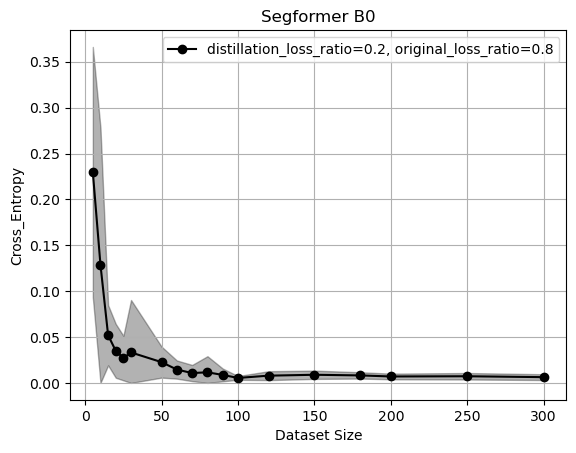

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()